<a href="https://colab.research.google.com/github/Nancy-Shi/Networks_2_Vaccines/blob/main/Two_Vaccines_Main_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2-Layer Vaccine Model with Informtion, Cognition/Epidemic

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import math as math
from math import log
import seaborn as sns
import pandas as pd
import matplotlib.ticker as ticker

In [4]:
# Generate Degree Sequence
def generate_degree_sequence(n, gamma, kmin):
    # Generate a random set from the power law distribution
    u = np.random.uniform(size=n)
    degrees = np.ceil((1.0 - u) ** (-1.0 / (gamma - 1.0)))

    # Adjust degrees based on the minimum and maximum degree values
    kmax = int(np.sqrt(n))
    #kmax = int(((gamma-1)/(gamma-2) * n )** (1/gamma))  # max degree
    # kmax = int(1.5*n**(1/4)) # max degree allowed is 1.5*n^(1/4)
    degrees = degrees[(degrees >= kmin) & (degrees <= kmax)].astype(int)

    # Truncate or pad the sequence to match the length specified
    if len(degrees) >= n:
        degrees = degrees[:n]
    else:
        degrees = np.concatenate((degrees, np.full(n - len(degrees), kmin)))

    return degrees.tolist()

In [5]:
# Assign Thresholds
# Defines the parameters to be used
mu = 0.1
sigma = 0.05

# Function to assign thresholds to the individual nodes
def assign_thresholds(hypergraph, mu, sigma):
    NV = hypergraph.order()
    Ltre = {}

    for node in hypergraph.nodes():
          # Uniform distribution: #
          #Ltre[node] = np.random.uniform()
          # Normal distrution
          while True:
              threshold = random.gauss(mu, sigma)
              if 0 < threshold < 1:
                  break
          Ltre[node] = threshold

    return Ltre

In [1]:
def Vaccine_model(inw, ldeg_i, ltre, enw, ldeg_e, lam, alp, omega, sigma, zeta_info, zeta_epi, phi, beta_1, beta_2, beta_3, mu, n_sample):

  t_max = 1000     # Set maximum time
  kmax_i = max (ldeg_i)     # Get maximum hyperedge degree in information layer
  kmax_e = max (ldeg_e)     # Get maximum degree in epidemic layer
  N = inw.order()  # Get the network size

  rho_A = []  # Keep track of fraction of stilfers in information layer
  rho_C = []   # Keep track of fraction of corrected in information layer
  rho_V1 = []   # Keep track of fraction of vaccinated with vaccine type 1 in epidemic layer
  rho_V2 = []   # Keep track of fraction of vaccinated with vaccine type 2 in epidemic layer
  rho_R = []   # Keep track of fraction of recovered in epidemic layer

  for i_samp in range(1, n_sample + 1):
      t = 0                 # Initialize time, number of corrected, number of recovered
      N_corrected = 0
      N_recovered = 0
      N_stifler = 0

      info_states = {j: "U" for j in inw.nodes()}   # Initialize information and disease states
      disease_states = {k: "S" for k in enw.nodes()}

      gossip = []     # Create lists to store gossip and corrected individuals in information layer
      corrected = []
      stifler = []

      N_gossip = 0
      N_e_i = 0
      #rumor_node_0 = np.random.choice(list(inw.nodes()))   # Pick a random person to start misinformaiton spreading
      #info_states[rumor_node_0] = "G"
      #gossip.append(rumor_node_0)
      #N_gossip = 1
      #N_e_i = inw.degree(rumor_node_0)

      susceptible = list(enw.nodes())
      infected = []     # Create lists to store infected and recovered individuals in epidemic layer
      recovered = []
      vaccinated_first = []
      vaccinated_second = []
      N_vaccine_1 = 0
      N_vaccine_2 = 0

      N_infected = 0
      N_e_e = 0
      for _ in range(10):
          ill_node_0 = np.random.choice([node for node, state in disease_states.items() if state == "S" and node in enw.nodes()])
          disease_states[ill_node_0] = "I"
          infected.append(ill_node_0)
          N_infected += 1
          N_e_e += enw.degree(ill_node_0)

      #ill_node_0 = np.random.choice(list(enw.nodes()))   # Pick a random person to start disease spreading
      #disease_states[ill_node_0] = "I"
      #infected.append(ill_node_0)
      #N_infected = 1
      #N_e_e = enw.degree(ill_node_0)

      time_record= [0]
      gossip_count = [0]
      stifler_count = [0]
      corrected_count = [0]
      V1_count = [0]
      V2_count = [0]
      recovered_count = [0]

      beta_max = max(beta_1,beta_2,beta_3)

      while t < 150 and N_infected > 0:
          total_rate = lam * N_e_i + 2 * alp * N_e_i + beta_max * N_e_e + mu * N_infected + zeta_info * (N-N_gossip) + zeta_epi * (N-N_vaccine_1) + omega * N_stifler + sigma * N_gossip
          tau = -np.log(np.random.uniform(1e-6, 1)) / total_rate
          t += tau

          if t >= t_max:
                break

          # Determine which event occurs
          event = np.random.uniform()
          p1 = (lam * N_e_i) / total_rate     # rumor spreading
          p2 = (lam * N_e_i + alp * N_e_i) / total_rate  # rumor stifling (by meeting stifling neighbor threshold)
          p3 = (lam * N_e_i + 2 * alp * N_e_i) / total_rate  # rumor stifling (by meeting gossip neighbor threshold)

          p4 = (lam * N_e_i + 2 * alp * N_e_i + beta_max * N_e_e) / total_rate  # disease propagation
          p5 = (lam * N_e_i + 2 * alp * N_e_i + beta_max * N_e_e + mu * N_infected) / total_rate  # disease recovery

          p6 = (lam * N_e_i + 2 * alp * N_e_i + beta_max * N_e_e + mu * N_infected + zeta_info * (N-N_gossip)) / total_rate # get vaccine 1 by information
          p7 = (lam * N_e_i + 2 * alp * N_e_i + beta_max * N_e_e + mu * N_infected + zeta_info * (N-N_gossip) + zeta_epi * (N-N_vaccine_1)) / total_rate # get vaccine 1 by cognition
          p8 = (lam * N_e_i + 2 * alp * N_e_i + beta_max * N_e_e + mu * N_infected + zeta_info * (N-N_gossip) + zeta_epi * (N-N_vaccine_1) + omega * N_stifler) / total_rate # rumor interest renewal


          # Case 1: Rumor spreading (Pairwise Threshold)
          if event < p1:
                response='F'
                while len(gossip)>0 and response =='F':
                  gossip_node = np.random.choice(gossip) #chose an infected node proportional to the degree
                  draw_rn = np.random.uniform()
                  if draw_rn < inw.degree(gossip_node)/kmax_i:
                     response='T'

                neighbors = list(inw.neighbors(gossip_node))
                neighbor = np.random.choice(neighbors)
                if info_states[neighbor] == "U":
                          count_gossip_neighbors = sum(1 for node in inw.neighbors(neighbor) if info_states[node] == "G")
                          if count_gossip_neighbors / len(list(inw.neighbors(neighbor))) >= ltre[neighbor]:
                                info_states[neighbor] = "G"  # uninformed neighbor becomes gossip spreader
                                gossip.append(neighbor)
                                N_gossip += 1
                                N_e_i += inw.degree(neighbor)
                                time_record.append(t)
                                gossip_count.append(N_gossip)
                                stifler_count.append(N_stifler)
                                corrected_count.append(N_corrected)
                                V1_count.append(N_vaccine_1)
                                V2_count.append(N_vaccine_2)
                                recovered_count.append(N_recovered)

          # Case 2: Rumor stifling (by meeting corrected stiflers) (Pairwise Threshold)
          elif event < p2:
                response='F'
                while len(gossip)>0 and response =='F':
                      stifler_node = np.random.choice(gossip) #chose an infected node proportional to the degree
                      draw_rn = np.random.uniform()
                      if draw_rn < inw.degree(stifler_node)/kmax_i:
                         response='T'

                neighbors = inw.neighbors(stifler_node)
                count_stifler_neighbors = sum(1 for node in inw.neighbors(stifler_node) if info_states[node] == "C")
                if count_stifler_neighbors / len(list(neighbors)) >= ltre[stifler_node]:
                            info_states[stifler_node] = "A"
                            N_gossip -= 1
                            gossip.remove(stifler_node)
                            stifler.append(stifler_node)
                            N_stifler += 1
                            N_e_i -= inw.degree(stifler_node)
                            time_record.append(t)
                            gossip_count.append(N_gossip)
                            stifler_count.append(N_stifler)
                            corrected_count.append(N_corrected)
                            V1_count.append(N_vaccine_1)
                            V2_count.append(N_vaccine_2)
                            recovered_count.append(N_recovered)

          # Case 3: Rumor stifling (by meeting gossip spreaders) (Pairwise Threshold)
          elif event < p3:
                response='F'
                while len(gossip)>0 and response =='F':
                      stifler_node = np.random.choice(gossip) #chose an infected node proportional to the degree
                      draw_rn = np.random.uniform()
                      if draw_rn < inw.degree(stifler_node)/kmax_i:
                         response='T'

                neighbors = inw.neighbors(stifler_node)
                count_gossip_neighbors = sum(1 for node in inw.neighbors(stifler_node) if info_states[node] == "G")
                if count_gossip_neighbors / len(list(neighbors)) >= ltre[stifler_node]:
                            info_states[stifler_node] = "A"
                            N_gossip -= 1
                            gossip.remove(stifler_node)
                            stifler.append(stifler_node)
                            N_stifler += 1
                            N_e_i -= inw.degree(stifler_node)
                            time_record.append(t)
                            gossip_count.append(N_gossip)
                            stifler_count.append(N_stifler)
                            corrected_count.append(N_corrected)
                            V1_count.append(N_vaccine_1)
                            V2_count.append(N_vaccine_2)
                            recovered_count.append(N_recovered)

          # Case 4: Disease propagation
          elif event < p4:
              response='F'
              while len(infected)>0 and response =='F':  #draw node until degree distribution is reached and while the infected list is not empty
                infected_node = np.random.choice(infected) #choose an infected node proportional to the degree
                draw_rn = np.random.uniform()
                if draw_rn < enw.degree(infected_node)/kmax_e: # kmax_e is the global max degree
                  response='T'
              neighbors = list(enw.neighbors(infected_node))
              #susceptible_or_vaccinated_neighbors = [n for n in neighbors if (disease_states[n] == "S" or disease_states[n] == "V1" or disease_states[n] == "V2")]


              target_node = np.random.choice(neighbors)
              if disease_states[target_node] == "S" or disease_states[target_node] == "V1" or disease_states[target_node] == "V2":
                  if disease_states[target_node] == "V1":
                      beta_correct = beta_2
                  elif disease_states[target_node] == "V2":
                      beta_correct = beta_3
                  else:
                      beta_correct = beta_1

                  draw_rn = np.random.uniform()
                  if draw_rn < beta_correct/beta_max:
                      disease_states[target_node] = "I"
                      infected.append(target_node)
                      N_infected += 1
                      N_e_e += enw.degree(target_node)
                      time_record.append(t)
                      gossip_count.append(N_gossip)
                      stifler_count.append(N_stifler)
                      corrected_count.append(N_corrected)
                      V1_count.append(N_vaccine_1)
                      V2_count.append(N_vaccine_2)
                      recovered_count.append(N_recovered)

                      ## Start gossip after epidemic have started
                      if N_gossip == 0:
                          for _ in range(10):
                                rumor_node_0 = np.random.choice([node for node, state in info_states.items() if state == "U" and node in inw.nodes()])
                          #uninformed = [node for node, state in info_states.items() if state == "U" and node in inw.nodes()]
                          #if len(uninformed) > 0:
                                #rumor_node_0 = np.random.choice(uninformed)
                                info_states[rumor_node_0] = "G"
                                gossip.append(rumor_node_0)
                                N_gossip += 1
                                N_e_i += inw.degree(rumor_node_0)
                                time_record.append(t)
                                gossip_count.append(N_gossip)
                                stifler_count.append(N_stifler)
                                corrected_count.append(N_corrected)
                                V1_count.append(N_vaccine_1)
                                V2_count.append(N_vaccine_2)
                                recovered_count.append(N_recovered)


          # Case 5: Disease recovery
          elif event < p5:
                recovered_node = np.random.choice(infected)
                disease_states[recovered_node] = "R"
                infected.remove(recovered_node)
                recovered.append(recovered_node)
                N_infected -= 1
                N_recovered += 1
                N_e_e -= enw.degree(recovered_node)
                time_record.append(t)
                gossip_count.append(N_gossip)
                stifler_count.append(N_stifler)
                corrected_count.append(N_corrected)
                V1_count.append(N_vaccine_1)
                V2_count.append(N_vaccine_2)
                recovered_count.append(N_recovered)

          # Case 6: Get vaccine 1 based on information layer
          # rate = zeta_info * (1 - n_G / k_info)
          elif event < p6:
            if len(susceptible) > 0:
                node_to_vaccinate = np.random.choice(susceptible)
                n_G = sum(1 for node in filter(lambda x: info_states[x] == "G", inw.neighbors(node_to_vaccinate)))
                k_info = len(list(inw.neighbors(node_to_vaccinate)))
                if np.random.uniform() < zeta_info * (1 - n_G / k_info):
                    draw_rn = np.random.uniform()
                    if t > 30 and draw_rn > phi:  #90
                        disease_states[node_to_vaccinate] = "V2"
                        susceptible.remove(node_to_vaccinate)
                        vaccinated_second.append(node_to_vaccinate)
                        N_vaccine_2 += 1
                        time_record.append(t)
                        gossip_count.append(N_gossip)
                        stifler_count.append(N_stifler)
                        corrected_count.append(N_corrected)
                        V1_count.append(N_vaccine_1)
                        V2_count.append(N_vaccine_2)
                        recovered_count.append(N_recovered)
                    else:
                        disease_states[node_to_vaccinate] = "V1"
                        susceptible.remove(node_to_vaccinate)
                        vaccinated_first.append(node_to_vaccinate)
                        N_vaccine_1 += 1
                        time_record.append(t)
                        gossip_count.append(N_gossip)
                        stifler_count.append(N_stifler)
                        corrected_count.append(N_corrected)
                        V1_count.append(N_vaccine_1)
                        V2_count.append(N_vaccine_2)
                        recovered_count.append(N_recovered)


          # Case 7: Get vaccine 1 based on vaccination level
          # k_epi is the total neighbor count on the epidemics layer
          elif event < p7:
            if len(susceptible) > 0:
                node_to_vaccinate = np.random.choice(susceptible)
                n_V1 = sum(1 for node in filter(lambda x: disease_states[x] == "V1", enw.neighbors(node_to_vaccinate)))
                #n_V2 = sum(1 for node in filter(lambda x: disease_states[x] == "V2", enw.neighbors(node_to_vaccinate)))
                k_epi = len(list(enw.neighbors(node_to_vaccinate)))
                if np.random.uniform() < zeta_epi * (1 - (n_V1 / k_epi)):
                    draw_rn = np.random.uniform()
                    if t > 30 and draw_rn > phi:  #90
                        disease_states[node_to_vaccinate] = "V2"
                        susceptible.remove(node_to_vaccinate)
                        vaccinated_second.append(node_to_vaccinate)
                        N_vaccine_2 += 1
                        time_record.append(t)
                        gossip_count.append(N_gossip)
                        stifler_count.append(N_stifler)
                        corrected_count.append(N_corrected)
                        V1_count.append(N_vaccine_1)
                        V2_count.append(N_vaccine_2)
                        recovered_count.append(N_recovered)
                    else:
                        disease_states[node_to_vaccinate] = "V1"
                        susceptible.remove(node_to_vaccinate)
                        vaccinated_first.append(node_to_vaccinate)
                        N_vaccine_1 += 1
                        time_record.append(t)
                        gossip_count.append(N_gossip)
                        stifler_count.append(N_stifler)
                        corrected_count.append(N_corrected)
                        V1_count.append(N_vaccine_1)
                        V2_count.append(N_vaccine_2)
                        recovered_count.append(N_recovered)

          # Case 8: Rumor interest renewal
          elif event < p8:
            if len(stifler) > 0:
                  stifler_node = np.random.choice(stifler)
                  info_states[stifler_node] = "U"
                  stifler.remove(stifler_node)
                  N_stifler -= 1
                  time_record.append(t)
                  gossip_count.append(N_gossip)
                  stifler_count.append(N_stifler)
                  corrected_count.append(N_corrected)
                  V1_count.append(N_vaccine_1)
                  V2_count.append(N_vaccine_2)
                  recovered_count.append(N_recovered)

          # Case 9: Correction of rumor
          else:
            if len(gossip)>0:
                node = np.random.choice(gossip) #chose an infected node proportional to the degree
                info_states[node] = "C"
                N_gossip -= 1
                gossip.remove(node)
                corrected.append(node)
                N_corrected += 1
                N_e_i -= inw.degree(node)
                time_record.append(t)
                gossip_count.append(N_gossip)
                stifler_count.append(N_stifler)
                corrected_count.append(N_corrected)
                V1_count.append(N_vaccine_1)
                V2_count.append(N_vaccine_2)
                recovered_count.append(N_recovered)

  return time_record, gossip_count, stifler_count, corrected_count, V1_count, V2_count, recovered_count


      #if N_infected == 0:
      #    stifler_frac = N_stifler / N
      #    corrected_frac = N_corrected / N
      #    vaccine_1_frac = N_vaccine_1 / N
      #    vaccine_2_frac = N_vaccine_2 /N
      #    recovered_frac = N_recovered / N
      #    rho_A.append(stifler_frac)
      #    rho_C.append(corrected_frac)
      #    rho_V1.append(vaccine_1_frac)
      #    rho_V2.append(vaccine_2_frac)
      #    rho_R.append(recovered_frac)



  ##if len(rho_A) > 0 and len(rho_C) > 0 and len(rho_V1) > 0 and len(rho_V2) > 0 and len(rho_R) > 0:
  #avg_rho_A = sum(rho_A) / len(rho_A)
  #avg_rho_C = sum(rho_C) / len(rho_C)
  #avg_rho_V1 = sum(rho_V1) / len(rho_V1)
  #avg_rho_V2 = sum(rho_V2) / len(rho_V2)
  #avg_rho_R = sum(rho_R) / len(rho_R)

  #return avg_rho_A, avg_rho_C, avg_rho_V1, avg_rho_V2, avg_rho_R


In [7]:
n = 1000  # Number of nodes

# Information Layer
gamma_i = 2.5
kmin_i = 3
ldeg_i = generate_degree_sequence(n, gamma_i, kmin_i)
print("Degree Sequence: ", ldeg_i)
inw = nx.configuration_model(ldeg_i)
ltre = assign_thresholds(inw, 0.10, 0.05)

Degree Sequence:  [7, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 5, 3, 4, 6, 6, 3, 6, 6, 3, 5, 10, 5, 3, 13, 3, 14, 4, 15, 6, 3, 3, 4, 3, 9, 12, 9, 5, 10, 3, 13, 4, 3, 7, 15, 9, 5, 3, 3, 3, 3, 3, 3, 5, 5, 3, 5, 19, 5, 3, 7, 4, 17, 3, 6, 4, 3, 3, 3, 7, 8, 3, 3, 3, 6, 5, 3, 4, 3, 19, 5, 7, 4, 4, 3, 3, 3, 5, 3, 3, 5, 9, 3, 3, 4, 3, 5, 8, 5, 6, 3, 3, 4, 3, 17, 3, 4, 5, 3, 21, 3, 5, 3, 8, 11, 9, 3, 6, 4, 6, 4, 3, 4, 3, 3, 3, 4, 3, 5, 3, 3, 14, 5, 8, 6, 5, 3, 3, 5, 3, 5, 7, 5, 3, 3, 9, 3, 14, 3, 3, 3, 4, 3, 3, 4, 5, 10, 4, 3, 3, 3, 4, 3, 3, 9, 4, 3, 3, 3, 4, 4, 3, 3, 15, 4, 12, 3, 3, 3, 3, 3, 4, 6, 3, 4, 5, 3, 12, 3, 5, 3, 3, 3, 3, 3, 3, 3, 4, 5, 3, 4, 4, 17, 3, 3, 3, 4, 4, 4, 3, 3, 7, 4, 3, 4, 4, 3, 13, 4, 3, 3, 3, 5, 5, 4, 4, 3, 6, 7, 7, 3, 6, 3, 5, 4, 4, 3, 4, 3, 4, 3, 5, 5, 8, 4, 27, 3, 5, 3, 3, 3, 8, 3, 3, 9, 12, 4, 4, 10, 6, 19, 3, 3, 3, 3, 4, 7, 3, 4, 3, 3, 5, 3, 7, 5, 8, 3, 4, 5, 4, 3, 8, 5, 5, 5, 3, 3, 12, 3, 3, 3, 3, 3, 4, 3, 6, 9, 4, 3, 3, 3, 15, 3, 4, 3, 3, 3, 3, 9, 3, 3, 8, 3, 17, 5, 4, 3, 6

In [8]:
# Epidemic Layer
gamma_e = 5.0 #4.0
kmin_e = 3
ldeg_e = generate_degree_sequence(n, gamma_e, kmin_e)
print("Degree Sequence: ", ldeg_e)
enw = nx.configuration_model(ldeg_e)
k = ((gamma_e-1)/(gamma_e-2))*(kmin_e) #<k>
k2 =((gamma_e-1)/(gamma_e-3))*((kmin_e)**2) #<k^2>
division_factor = (k2-k)/k # division factor to compute beta_max(<k^2>-<k>)/<k>
print(["<k>: ", k, "<k^2>: ", k2,"(<k^2>-<k>)/<k>: ",  division_factor])

Degree Sequence:  [3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [9]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [10]:
# Set parameters
lam = 1/2 #1/3 # gossip spreading rate
alp = 1/2 #1/3 # gossip stifling rate
omega = 1 #1/5 # gossip renewal rate
sigma = 0 # correction rate of misinformation

zeta_info = 0.05
zeta_epi = 0.02

mu = 0.2
R0 = 4.0 #4.0 (assume a COVID19-like disease for the reproduction number) 2.0 # reproduction number
beta_1 = R0 * mu / division_factor
beta_2 = beta_1*(1-0.76)
beta_3 = beta_1*(1-0.94)

phi = 0.4

n_sample = 1

In [11]:
time_record, gossip_count, stifler_count, corrected_count, V1_count, V2_count, recovered_count = Vaccine_model(inw, ldeg_i, ltre, enw, ldeg_e, lam, alp, omega, sigma, zeta_info, zeta_epi, phi, beta_1, beta_2, beta_3, mu, n_sample)


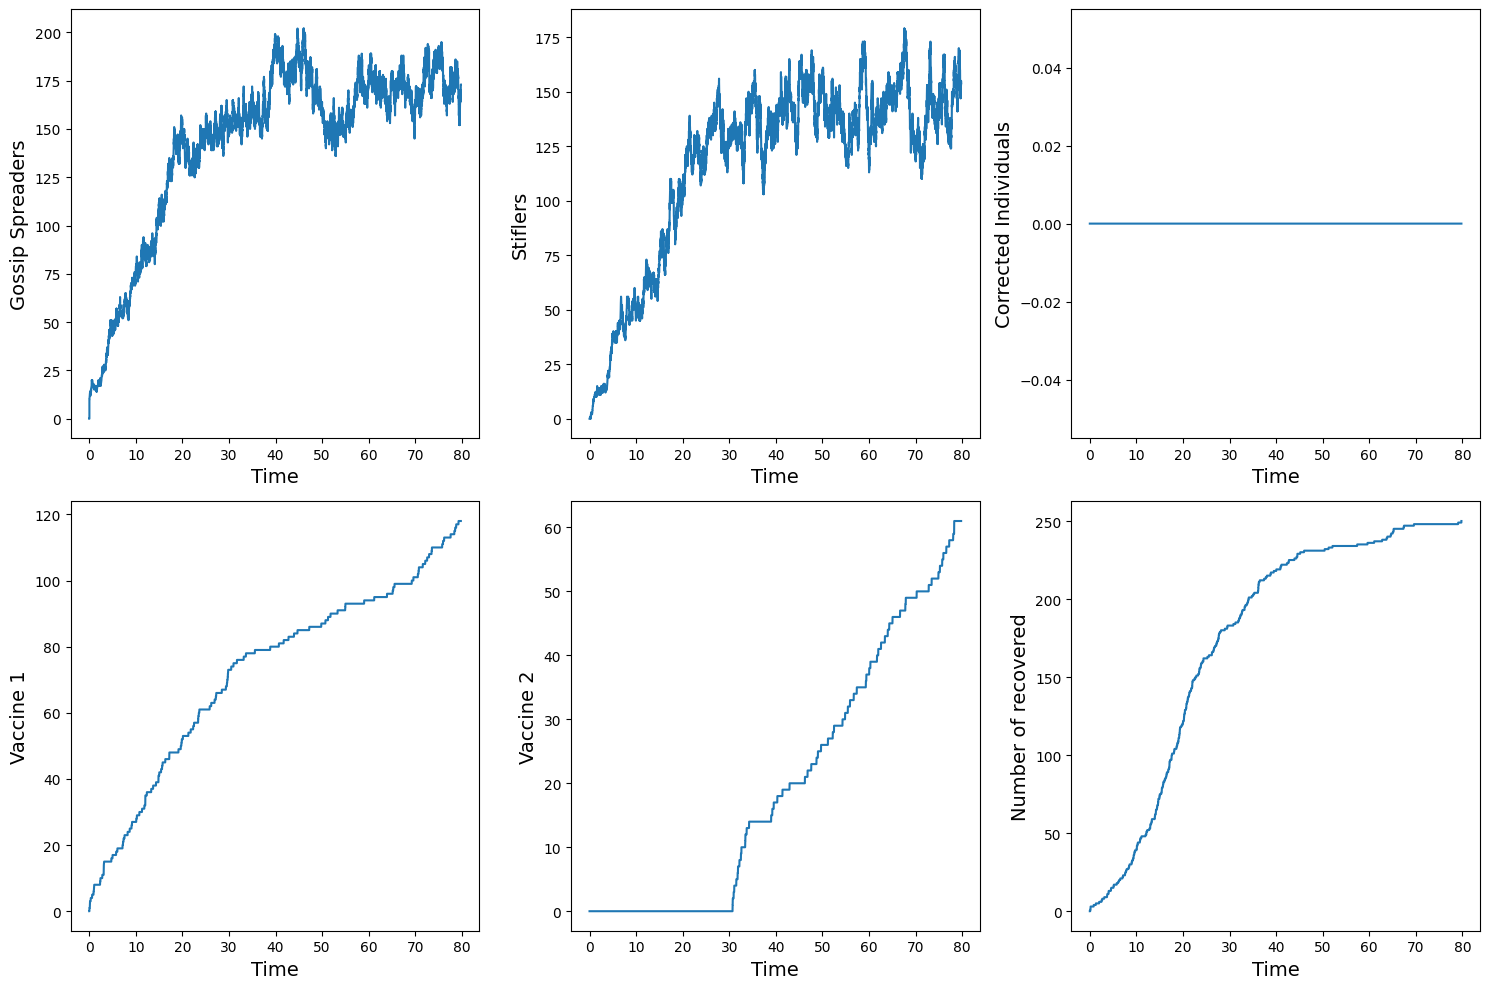

In [12]:
import matplotlib.pyplot as plt

# Create subplots
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1 - number of gossip
ax1.plot(time_record, gossip_count)
ax1.set_xlabel(r'Time', fontsize=14)
ax1.set_ylabel(r'Gossip Spreaders', fontsize=14)

# Plot 2 - stifler count
ax2.plot(time_record, stifler_count)
ax2.set_xlabel(r'Time', fontsize=14)
ax2.set_ylabel(r'Stiflers', fontsize=14)

# Plot 3 - corrected count
ax3.plot(time_record, corrected_count)
ax3.set_xlabel(r'Time', fontsize=14)
ax3.set_ylabel(r'Corrected Individuals', fontsize=14)

# Plot 4 - number of protected
ax4.plot(time_record, V1_count)
ax4.set_xlabel(r'Time', fontsize=14)
ax4.set_ylabel(r'Vaccine 1', fontsize=14)

# Plot 5 - prevalence
ax5.plot(time_record, V2_count)
ax5.set_xlabel(r'Time', fontsize=14)
ax5.set_ylabel(r'Vaccine 2', fontsize=14)

# Plot 6 - total recovered
ax6.plot(time_record, recovered_count)
ax6.set_xlabel(r'Time', fontsize=14)
ax6.set_ylabel(r'Number of recovered', fontsize=14)

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()